In [75]:
import matplotlib.pyplot as plt
import pennylane as qml
import scipy as sp

from pennylane import numpy as np
from IPython.display import display, Math

np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions()

dev = qml.device('default.qubit', wires= 2)

pauli_y = np.array([ [0, -1.j], [1.j, 0]])

# Hamiltonian_new = 0.2*np.kron(sigma_x, sigma_z) -0.543*np.kron(sigma_z, sigma_x)
# Hamiltonian setup
coeffs = [0.2, -0.543]
obs = [qml.PauliX(0) @ qml.PauliZ(1), qml.PauliZ(0) @ qml.PauliX(1)]
# print('Data type:', type(obs))

hamiltonian = qml.Hamiltonian(coeffs, obs)

print('Hamiltonian:\n',hamiltonian)

Hamiltonian:
   (-0.543) [Z0 X1]
+ (0.2) [X0 Z1]


In [76]:
# == Quantum circuit ==
@qml.qnode(dev)
def circuit(theta_init, tau_1, tau_2):
    
	qml.ApproxTimeEvolution(hamiltonian, tau_1, 1)
	qml.RX(theta_init, wires = 0)    
	qml.RX(theta_init, wires = 1)    
	 
	qml.RY(-np.pi/2, wires = 0)    
	qml.RY(-np.pi/2, wires = 1)   
	
	qml.ApproxTimeEvolution(hamiltonian, tau_2, 1)
	
	qml.RY(np.pi/2, wires = 0)    
	qml.RY(np.pi/2, wires = 1) 

	return qml.density_matrix(wires=[0, 1])

In [77]:
# == Calculate concurrence ==
def concurrence_calculation(paras):

	theta_init, tau_1, tau_2 = paras
 
	# density matrix casting to numpy
	rho = circuit(theta_init, tau_1, tau_2).numpy()
	rho_uni = np.kron(pauli_y, pauli_y) @ rho.conj() @ np.kron(pauli_y, pauli_y)
	
	R = sp.linalg.sqrtm( sp.linalg.sqrtm(rho) @ rho_uni @ sp.linalg.sqrtm(rho) )
	# print('Concurrence matrix(R): \n', R)

	# sort array in descending order
	eig_vals = np.sort(sp.linalg.eigvals(R).real)[::-1]
	# print('Eig_val descending order:', eig_vals)

	concurrence = np.amax([ 0, (2*eig_vals[0] - np.sum(eig_vals)) ])	
	# concurrence = 0 vs (2*eig_vals[0] - np.sum(eig_vals)) which is bigger?
	# print('np.amax:', -concurrence)


	# 1-concurrence = minimum => concurrence = max!!
	return 1-concurrence

0.5336425994876177

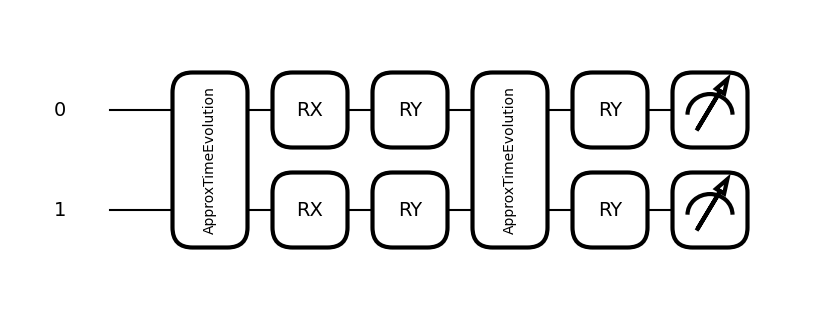

In [78]:
# == Show circuit ==
rho = (circuit(0, 1, 1))
fig, ax = qml.draw_mpl(circuit)(0, 1, 1)

para = 1,1,1
concurrence_calculation(para)

In [79]:
# == Optimize begin from 0.5 ==

# starts from 0.5
# starts = 0.5, 0.5, 0.5
Init_parameters = 1,1,1
result = sp.optimize.minimize(concurrence_calculation, Init_parameters, method='SLSQP')

# 1-concurrence = x => concurrence = -(x-1)
# -1 * concurrence = x  => concurrence = -1 * (x)
print('\n\nconcurrence_after_optimize(max): ', -1 * (concurrence_calculation(result.x)-1) )

result



concurrence_after_optimize(max):  0.9976959789772726


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0023040210227274205
       x: [ 5.029e-01  1.572e+00  8.262e-01]
     nit: 5
     jac: [ 1.549e-01  1.775e-01  7.157e-01]
    nfev: 36
    njev: 5

In [80]:
# == Put optimized paramter into circuit() and return density matrix ==
rho = circuit(result.x[0], result.x[1], result.x[2]).numpy()

rho_real = np.real(rho)
rho_imag = np.imag(rho)

# Density matrix after optimzed
print('(Optimized) theta_init / tau_1 / tau_2 : ', result.x)
print('\n',rho_real)

(Optimized) theta_init / tau_1 / tau_2 :  [0.50290761 1.57193978 0.82615675]

 [[ 1.80639825e-01 -4.24103005e-17  1.82302548e-17 -2.00539784e-01]
 [-4.24103005e-17  3.04138280e-01 -2.98308210e-01  4.37098586e-17]
 [ 1.82302548e-17 -2.98308210e-01  2.92589897e-01 -1.69306967e-17]
 [-2.00539784e-01  4.37098586e-17 -1.69306967e-17  2.22631998e-01]]


In [81]:
# == Double check the calculation ==

sigma_x = np.array([ [0, 1], [1, 0] ])
sigma_y = np.array([ [0, -1.j], [1.j, 0] ])
sigma_z = np.array([ [1, 0], [0, -1] ])

theta_init, tau_1, tau_2 = result.x

Hamiltonian_new = 0.2*np.kron(sigma_x, sigma_z) -0.543*np.kron(sigma_z, sigma_x)

# define rotation
# why kron? : Multiple qubit
def X_rot(theta):
    return np.kron(sp.linalg.expm(-1j*sigma_x*theta/2), sp.linalg.expm(-1j*sigma_x*theta/2))

def Y_rot(theta):
    # return sp.linalg.expm(-1j*sigma_y*theta/2)
    return np.kron(sp.linalg.expm(-1j*sigma_y*theta/2), sp.linalg.expm(-1j*sigma_y*theta/2))

def time_evolve_new(tau):
    return sp.linalg.expm(-1.j*Hamiltonian_new*tau)


# State vector form(: 4*1 matrix)
test = Y_rot(np.pi/2) @ time_evolve_new(tau_2) @ Y_rot(-np.pi/2) @ X_rot(theta_init) @ time_evolve_new(tau_1) @ np.array([1,0,0,0]).reshape(4,1)

# state vector 
print('test:\n',X_rot(2*np.pi))
print('test:\n',np.kron(sigma_x, sigma_x))

# Unitary
# Create density matrix
result_after = np.kron(test, np.conj(test).T)



print('Optimized parameters: ', result.x)

print('\nLayer matrix\n',test)
print('\nFrom Q_node:\n',rho)
print('\nDouble check density matrix:\n', result_after)

test:
 [[ 1.00000000e+00-0.0000000e+00j  0.00000000e+00+1.2246468e-16j  0.00000000e+00+1.2246468e-16j -1.49975978e-32-0.0000000e+00j]
 [ 0.00000000e+00+1.2246468e-16j  1.00000000e+00-0.0000000e+00j -1.49975978e-32-0.0000000e+00j  0.00000000e+00+1.2246468e-16j]
 [ 0.00000000e+00+1.2246468e-16j -1.49975978e-32-0.0000000e+00j  1.00000000e+00-0.0000000e+00j  0.00000000e+00+1.2246468e-16j]
 [-1.49975978e-32-0.0000000e+00j  0.00000000e+00+1.2246468e-16j  0.00000000e+00+1.2246468e-16j  1.00000000e+00-0.0000000e+00j]]
test:
 [[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]]
Optimized parameters:  [0.50290761 1.57193978 0.82615675]

Layer matrix
 [[ 4.25017440e-01-7.47175388e-17j]
 [-3.27706644e-17+5.51487334e-01j]
 [-3.64784690e-17-5.40915795e-01j]
 [-4.71838954e-01-1.21501713e-18j]]

From Q_node:
 [[ 1.80639825e-01+0.00000000e+00j -4.24103005e-17-2.34391735e-01j  1.82302548e-17+2.29898647e-01j -2.00539784e-01+2.59911611e-18j]
 [-4.24103005e-17+2.34391735e-01j  3.04138280e-01+0.00000000e+00j -2.983

$$X = 
\exp\left(-i \frac{\sigma_x \theta}{2}\right) = \cos\left(\frac{\theta}{2}\right)I - i\sin\left(\frac{\theta}{2}\right)\sigma_x $$


In [82]:
np.isclose(result_after, rho)

tensor([[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]], requires_grad=True)

In [83]:
rho_real, rho_imag

(tensor([[ 1.80639825e-01, -4.24103005e-17,  1.82302548e-17, -2.00539784e-01],
         [-4.24103005e-17,  3.04138280e-01, -2.98308210e-01,  4.37098586e-17],
         [ 1.82302548e-17, -2.98308210e-01,  2.92589897e-01, -1.69306967e-17],
         [-2.00539784e-01,  4.37098586e-17, -1.69306967e-17,  2.22631998e-01]], requires_grad=True),
 tensor([[ 0.00000000e+00, -2.34391735e-01,  2.29898647e-01,  2.59911611e-18],
         [ 2.34391735e-01,  0.00000000e+00, -3.03202777e-17, -2.60213207e-01],
         [-2.29898647e-01,  3.03202777e-17,  0.00000000e+00,  2.55225143e-01],
         [-2.59911611e-18,  2.60213207e-01, -2.55225143e-01,  0.00000000e+00]], requires_grad=True))

/var/folders/w1/ls_y8xbd21b7x0tbqwgfdcd00000gn/T/ipykernel_38709/3071425353.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(state)
/var/folders/w1/ls_y8xbd21b7x0tbqwgfdcd00000gn/T/ipykernel_38709/3071425353.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(state)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


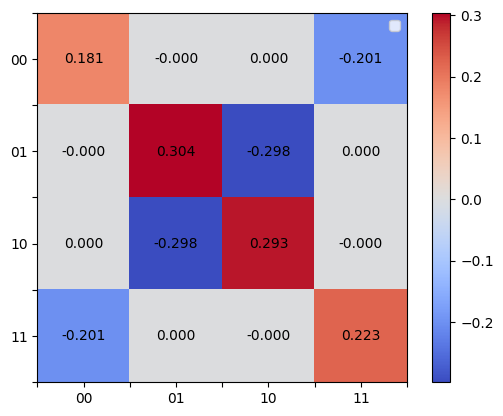

In [84]:
# fig, ax = plt.subplots()
state = ["",'00',"",'01',"",'10',"",'11']
fig, ax = plt.subplots()
plt.imshow(rho_real, cmap="coolwarm")
plt.colorbar()
ax.set_xticklabels(state)
ax.set_yticklabels(state)
# ax.set_ylabel("qubit 1")
# ax.set_xlabel("qubit 2")
# ax.set_title(r"Target density matrix $\rho_{3}$")


for (j,i),label in np.ndenumerate(rho_real):
    ax.text(i,j, "{:.3f}".format(label),ha="center", va="center")
ax.legend()
plt.show()